metadata is here for census tract https://www2.census.gov/geo/tiger/TIGER_DP/2019ACS/Metadata/TRACT_METADATA_2019.txt

here for block group https://www2.census.gov/geo/tiger/TIGER_DP/2019ACS/Metadata/BG_METADATA_2019.txt

USE 2019 census data

use init epsg for projection

## functions




In [4]:
!pip install simpledbf

  Preparing metadata (setup.py) ... done
  Created wheel for simpledbf: filename=simpledbf-0.2.6-py3-none-any.whl size=13801 sha256=12da8a1ba39cf0d6382601bdc28ff8d72e31e6ced013cc6d96094abee5a5cc58
  Stored in directory: /home/jupyter/.cache/pip/wheels/24/43/f4/39ad84349e5358346be977fe626160f5625fdd3ea8e017518c
Successfully built simpledbf


only need to unzip the csv files

In [1]:
# Parameters
pctShapefile = "nj_vest_20_vtd_estimates.zip"
BGShapefile = "ACS_2019_5YR_BG_34.gdb.zip"
BGGeometryLayer = 24
tractShapefile = "ACS_2019_5YR_TRACT_34.gdb.zip"
tractGeometryLayer = 31
state = "NEW_JERSEY"
#census region the state is in; options are South, Northeast, Midwest, West
region="Northeast"
stateFIPS = "34"
blockData = (
    "DECENNIALSF12010.P1-Data.csv")
#until ACS data comes out for 2020 block groups, it makes more sense to use 2010 block groups to construct the precinct dict
#still can use 2020 redistricting data for race and population data
blockData2020 =    "DECENNIALPL2020.P4-Data.csv"
blockShapefile = "tl_2016_34_tabblock10.zip"
blockShapefile2020 = "tl_2020_34_tabblock20.zip"
pctNameField = "ELECD_KEY"
prisonDFName = "prisonBlocks.DBF"
#use two separate prison DFs for 2010 and 2020 geometry to avoid having to do unnecessary spatial joins 
prisonBlocks2020="DECENNIALPL2020.P5-Data.csv"
racesToInclude = ["black", "white","hispanic","asian"]


In [16]:
import pandas as pd
import geopandas as gpd
import os
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from matplotlib.colors import TwoSlopeNorm
from skbio.stats import composition
from simpledbf import Dbf5
from scipy import optimize
from scipy.special import logit,expit

#sometimes required to get map projections working in geopandas
#os.environ['PROJ_LIB']=r"C:\ProgramData\Anaconda3\Library\share"
#os.environ['GDAL_DATA'] = r"C:\ProgramData\Anaconda3\Library\share\gdal"
import matplotlib.pyplot as plt
import contextily as ctx
#norm=TwoSlopeNorm(vmin=0,vcenter=.5,vmax=1)
from matplotlib.colors import TwoSlopeNorm
def correctEduByRace(row):
        #print(row)
        totallyDiff =row.copy()
        totallyDiff.index="%"+row.index.str.split("%").str[0]
        #print(totallyDiff.index)
        #row.rename()
        eduByRace=totallyDiff.clip(lower=.001,upper=.999)
        #make sure the race array is lined up with the race by pct array
        #print(row)
        #print(totallyDiff.rename({"%other":"%other_race"}).index)
        race= raceByPct.loc[totallyDiff.name].reindex(totallyDiff.rename({"%other":"%other_race"}).index)
        trueEdu= additionalFields.loc[totallyDiff.name,"%college"]
        offset= optimize.root(logOddsChange,0,args=(race,eduByRace,trueEdu))["x"][0]
        #print(offset)
        result = expit(logit(eduByRace)+offset)
        result.index=result.index.str.lstrip("%")+"%College"
        #print(test.columns)
        return result
def plotData(pctShp,data,column,basemap=False,zoom=8,vmin=None,vmax=None, 
             xlim=None,ylim=None,cmap="RdBu",norm=None,linewidth=.01,alpha=.6):
    if basemap == True:
        mapDF = pctShp.join(data).to_crs(epsg=3857)
        fig, ax = plt.subplots(figsize = (30,30))
        if norm is None:
            mapDF.plot(column=column,legend=True,cmap=cmap,ax=ax, alpha=alpha,vmin=vmin,
                       vmax=vmax,linewidth=linewidth)
            ctx.add_basemap(ax,zoom=zoom)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        if norm is not None:
            mapDF.plot(column=column,legend=True,cmap=cmap,ax=ax, alpha=alpha,vmin=vmin,
                vmax=vmax,norm=TwoSlopeNorm(vmin=norm[0],vcenter=norm[1],vmax=norm[2]),linewidth=linewidth)
            ctx.add_basemap(ax,zoom=zoom)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            

        
    else:
        mapDF = pctShp.join(data)
        fig, ax = plt.subplots(figsize = (30,30)) 
        if norm is None:
            mapDF.plot(column=column,legend=True,cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,
                      linewidth=linewidth)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        if norm is not None:
            mapDF.plot(column=column,legend=True,cmap=cmap,ax=ax,vmin=vmin,vmax=vmax
                ,norm=TwoSlopeNorm(vmin=norm[0],vcenter=norm[1],vmax=norm[2]),linewidth=linewidth)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
def to_ilr(df,name):
    #df["other"]=1-df.sum(axis=1)
    return pd.DataFrame(composition.ilr(composition.multiplicative_replacement(df)),
        index=df.index,columns=[name+f"_{i}" for i in range(len(df.columns)-1)]) 
def plotPrecinct(precinct,zoom=14):
    geoDataFrame = pctShp.loc[[precinct]].to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize = (40,32)) 
    geoDataFrame.geometry.plot(ax=ax, alpha=.5)
    ctx.add_basemap(ax,zoom=zoom)
def weightedMedianPopDensity(df):
    try:
        df.sort_values('pop density', inplace=True)
        cumsum = pd.concat([df.P4_001N.cumsum(),df["pop density"]],axis=1)
        cumsum = cumsum[cumsum.P4_001N>0]
        if len(cumsum)>0:
            halfway = df.P4_001N.sum() / 2.0
            return np.interp(halfway,cumsum.P4_001N.values,cumsum["pop density"].values)
        else:
            return 0

    except:
        print("error occured at precinct"+df.NAME.iloc[0])    
def getNearbyUrban(row):
    try:
        nearbyPcts= gpd.sjoin(pctCentroids,gpd.GeoDataFrame(geometry=row,crs=pctCentroids.crs), how="inner",
            op='intersects').set_index("NAME").join(censusPops2020["P4_001N"]
                ).join(pctPopDensity["density"])
        return nearbyPcts[nearbyPcts["density"]>4000].loc[:,"P4_001N"].sum()
    except:
        print("error at"+row.name)

def to_ilr(df,name):
    
    if (df.sum(axis=1) <.999).any():
        if (df.sum(axis=1) > 1.001).any():
            print("data sums to over 1? seems bad")
    
            return None
        else:
            df["other"]=1-df.sum(axis=1)
    #clip dataframe to prevent extremely large/small values introducing noise in log odds space
    df = df.clip(lower=.01,upper=.99).div(df.clip(lower=.01,upper=.99).sum(axis=1),axis=0)
    #print(df.min())
    return pd.DataFrame(composition.ilr(composition.multiplicative_replacement(df)),
        index=df.index,columns=[name+f"_{i}" for i in range(len(df.columns)-1)]) 
def createPercentages(df,sumCol=None,other=False,variables=None,name=None):
    if sumCol is None:
        newSum = df.sum(axis=1) 
        percentages= df.divide(newSum,axis=0)
    else:
        percentages =  df.divide(df[sumCol],axis=0).drop(sumCol,axis=1)
    if other == True:
        percentages["%other_"+name] = (1-percentages.sum(axis=1)).clip(lower=0)
    if variables is not None:
        percentages.rename(variables,inplace=True,axis=1)
    return percentages
def fixCode(codes):
    fixedCodes = []
    for code in codes:
        splitCode = code.split("_")
        fixedCodes.append( splitCode[0]+"e"+str(int(splitCode[1][:-1])))
    return fixedCodes
#one of names, codes must be provided
def BGDemographicsByPrecinct(BGShapefile,layer,BGPctDict,outputName,state,sumCol,names=None,codes=None):
    censusData = gpd.GeoDataFrame.from_file(BGShapefile,layer=layer)
    #changes GEOID to match GEOID in shapefile 
    censusData["BG"] = censusData["GEOID"].str[7:]
    censusData.set_index("BG",inplace=True)
    #gets the columns of data that we want
    if codes is None:
        codes = list(names.keys())
    totalCodes = codes+[sumCol]
    relevantData = pd.DataFrame(censusData.loc[:,totalCodes])
    
    #multiply by frac of BG in each precinct, then group by precinct
    intPctData = relevantData.mul(BGPctDict.frac,axis="index").groupby("NAME").aggregate("sum")
    #go from total number to % of pop
    dataByPct = createPercentages(intPctData,sumCol=sumCol,other=True,variables=names,name=outputName)
    
    #dataByPct.to_csv(outputName+state+".csv")
    return dataByPct
#one of names, codes must be provided
def intBGDemographicsByPrecinct(BGShapefile,layer,BGPctDict,outputName,state,sumCol,names=None,codes=None):
    censusData = gpd.GeoDataFrame.from_file(BGShapefile,layer=layer)
    #changes GEOID to match GEOID in shapefile 
    censusData["BG"] = censusData["GEOID"].str[7:]
    censusData.set_index("BG",inplace=True)
    #gets the columns of data that we want
    if codes is None:
        codes = list(names.keys())
    totalCodes = codes+[sumCol]
    relevantData = pd.DataFrame(censusData.loc[:,totalCodes])
    
    #multiply by frac of BG in each precinct, then group by precinct
    intPctData = relevantData.mul(BGPctDict.frac,axis="index").groupby("NAME").aggregate("sum")
    #go from total number to % of pop
    return intPctData
#one of names, codes must be provided

def tractDemographicsByPrecinct(tractShapefile,layer,tractPctDict,outputName,state,sumCol,names=None,codes=None):
    censusData = gpd.GeoDataFrame.from_file(tractShapefile,layer=layer)
    #changes GEOID to match GEOID in shapefile 
    censusData["Tract"] = censusData["GEOID"].str[7:]
    censusData.set_index("Tract",inplace=True)
    #gets the columns of data that we want
    if codes is None:
        codes = list(names.keys())
    totalCodes = codes+[sumCol]
    relevantData = pd.DataFrame(censusData.loc[:,totalCodes])
    
    #multiply by frac of BG in each precinct, then group by precinct
    intPctData = relevantData.mul(tractPctDict.frac,axis="index").groupby("NAME").aggregate("sum")
    #go from total number to % of pop
    dataByPct = createPercentages(intPctData,sumCol=sumCol,other=True,variables=names,name=outputName)
    
    #dataByPct.to_csv(outputName+state+".csv")
    return dataByPct
def intTractDemographicsByPrecinct(tractShapefile,layer,tractPctDict,outputName,state,sumCol,names=None,codes=None):
    censusData = gpd.GeoDataFrame.from_file(tractShapefile,layer=layer)
    #changes GEOID to match GEOID in shapefile 
    censusData["Tract"] = censusData["GEOID"].str[7:]
    censusData.set_index("Tract",inplace=True)
    #gets the columns of data that we want
    if codes is None:
        codes = list(names.keys())
    totalCodes = codes+[sumCol]
    relevantData = pd.DataFrame(censusData.loc[:,totalCodes])
    
    #multiply by frac of BG in each precinct, then group by precinct
    intPctData = relevantData.mul(tractPctDict.frac,axis="index").groupby("NAME").aggregate("sum")
    #go from total number to % of pop
    return intPctData


## import files

In [ ]:
#look for pct name field
pctData = gpd.GeoDataFrame.from_file(pctShapefile)
pctData.head(1)

In [4]:
pctShp = pctData[[pctNameField, "geometry"]].set_index(pctNameField,drop=False).rename({pctNameField:"NAME"},axis=1)
pctShp=pctShp[~pctShp.index.duplicated(keep="first")]

dbf = Dbf5(prisonDFName)
prisonDF = dbf.to_dataframe()

In [5]:
%%time
blockShp = gpd.GeoDataFrame.from_file(blockShapefile)
pctShp,blockShp = [i.to_crs("+init=epsg:4326") for i in [pctShp,blockShp]]
blockShp["centroid"]= blockShp.geometry.centroid
blockCentroids = gpd.GeoDataFrame(blockShp[["GEOID10","centroid"]],geometry="centroid",crs="+init=epsg:4326")
blockShp["area"]=blockShp[['ALAND10', 'AWATER10']].sum(axis=1)/(1609.34**2)

print("shapefiles imported")
blockPctJoin = gpd.sjoin(blockCentroids, pctShp, how="inner", op='intersects')
blockPctJoin.drop("index_right",axis=1,inplace=True)
blockPctJoin.set_index("GEOID10",inplace=True)
print("block join complete")

blockCensusData = pd.read_csv(blockData)
blockPops= blockCensusData[["GEO_ID","P001001"]].drop(blockCensusData.index[0])
blockPops.index = blockPops.GEO_ID.str.split("US").str[1]
blockPops.drop("GEO_ID",axis=1,inplace=True)

blockPctPops = blockPctJoin.join(blockPops,how="inner") 
blockPctPops.P001001 = pd.to_numeric(blockPctPops.P001001,errors="coerce")
blockPctPops["BG"]=blockPctPops.index.str[:-3]
blockPctPops["Tract"]=blockPctPops.index.str[:-4]
#remove blocks with prisons in them
#blockPctPops=blockPctPops[~blockPctPops.index.isin(prisonDF[prisonDF.STATE==stateFIPS].loc[prisonDF.POP>300].GEOID)]
print("block pops imported")

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https

shapefiles imported
block join complete
block pops imported
CPU times: user 1min 34s, sys: 1.68 s, total: 1min 36s
Wall time: 1min 37s


In [6]:
BGPopSplit = blockPctPops.groupby(["BG","NAME"]).aggregate(sum)
BGPopsOld = blockPctPops[["BG","P001001"]].groupby("BG").aggregate(sum)

#identify and remove block groups where >30% of the population is prisoners
prisonDF["BG"]=prisonDF.GEOID.str[:12]
#number of people in a group quarter in each block group
#should it be prisoners only?
prisonersByBG=prisonDF[(prisonDF.STATE==stateFIPS)][["BG","QGIC"]].groupby("BG").agg(sum)


BGPopSplit.loc[BGPopsOld.loc[(prisonersByBG.reindex(BGPopsOld.index).div(BGPopsOld.rename(
    {"P001001":"POP"},axis=1),axis=0).fillna(0)>.3)["POP"]].index,"P001001"]=0

BGPctDict = BGPopSplit.join(BGPopsOld,how="inner",rsuffix = "_BG")
BGPctDict["frac"]= BGPctDict.P001001/BGPctDict.P001001_BG
print("BG dict complete")
tractPopSplit =  blockPctPops.groupby(["Tract","NAME"]).aggregate(sum)
tractPopsOld = blockPctPops[["Tract","P001001"]].groupby("Tract").aggregate(sum)
tractPctDict = tractPopSplit.join(tractPopsOld,how="inner",rsuffix = "_tract")
tractPctDict["frac"]= tractPctDict.P001001/tractPctDict.P001001_tract
print("tract dict complete")
#if total BG/tract population is 0 then the frac of BG/tract in precinct will be NaN
#setting NaN values to 0  basically excludes geographies with 0 pop in 2010 from being used to calculate pct demographics
tractPctDict["frac"] = tractPctDict["frac"].fillna(0)
BGPctDict["frac"] = BGPctDict["frac"].fillna(0)

BG dict complete
tract dict complete


### get 2020 census data

In [7]:
blockShp2 = gpd.GeoDataFrame.from_file(blockShapefile2020).to_crs("+init=epsg:4326")
prisonBlocks2 = pd.read_csv(prisonBlocks2020,index_col=0,dtype="str").drop("Geography")
blockCensusData2 = pd.read_csv(blockData2020,index_col=0,dtype="str").drop("Geography")
prisonBlocks2=prisonBlocks2.apply(lambda row:pd.to_numeric(row,errors="ignore"))
blockCensusData2=blockCensusData2.apply(lambda row:pd.to_numeric(row,errors="ignore"))
prisonBlocks2["prisoners"]=prisonBlocks2["P5_003N"]
#can be over 1 b/c numer`ator counts minors and denom doesn't 
fracPrisoner=(prisonBlocks2["prisoners"]/blockCensusData2["P4_001N"]).fillna(0)
#remove census blocks that are largely prisoners
#almost all blocks with any prisoners are 90%+ prisoners so the exact cutoff doesn't matter much
blockCensusData2=blockCensusData2[fracPrisoner<.2].join(prisonBlocks2.iloc[:,np.r_[5:7,8:11]],how="inner")
blockCensusData2.index=blockCensusData2.index.str.split("US").str[1]

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [8]:
blockShp2["centroid"]= blockShp2.geometry.centroid
blockCentroids2 = gpd.GeoDataFrame(blockShp2[["GEOID20","centroid"]],geometry="centroid",crs="+init=epsg:4326")
#adds water and land area and converts to square miles
#can't use only land area for pop density calcs because there are some blocks that are only water but have people living there (??)
blockShp2["area"]=blockShp2[['ALAND20', 'AWATER20']].sum(axis=1)/(1609.34**2)
print("shapefiles imported")
blockPctJoin2 = gpd.sjoin(blockCentroids2, pctShp, how="inner", op='intersects')
blockPctJoin2.drop("index_right",axis=1,inplace=True)
blockPctJoin2.set_index("GEOID20",inplace=True)
print("block join complete")
blockPctJoin2020 = blockCensusData2.join(blockPctJoin2.NAME,rsuffix="_PCT").loc[:,"P4_001N":]
censusPops2020=blockPctJoin2020.apply(lambda row: pd.to_numeric(row,errors="ignore")).groupby("NAME_PCT").agg(sum)
censusRaceClean = pd.DataFrame(index=censusPops2020.index)
censusRaceClean["%NHWhite"]=censusPops2020["P4_005N"]/censusPops2020["P4_001N"]
censusRaceClean["%NHBlack"]=censusPops2020["P4_006N"]/censusPops2020["P4_001N"]
censusRaceClean["%hispanic"]=censusPops2020["P4_002N"]/censusPops2020["P4_001N"]
censusRaceClean["%NHAsian"]=censusPops2020["P4_008N"]/censusPops2020["P4_001N"]
censusRaceClean["%NHNative"]=censusPops2020["P4_007N"]/censusPops2020["P4_001N"]


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


shapefiles imported
block join complete


NameError: name 'pctPopsOld' is not defined

looks like P5_010N (other noninstitutional facilities) are like homeless shelters, homeless camps and church run transition programs?
p5_006N is basically irrelevant, no significant populations anywhere in GA at least

### pop density calcs


In [9]:
%%time
blockAreas = blockShp2[["GEOID20","area"]].set_index("GEOID20")
blockAreas.name ="area"
densityDF = blockPctJoin2.join(blockCensusData2["P4_001N"],how="inner").join(
    (blockCensusData2["P4_001N"]/blockAreas["area"]).fillna(0).rename("pop density"))
pctPopDensity = pd.DataFrame(densityDF.groupby("NAME").apply(weightedMedianPopDensity
                                                    ),columns=["density"])
print("pop density calculated")
pctPopDensity.name="density"

pop density calculated
CPU times: user 6.02 s, sys: 0 ns, total: 6.02 s
Wall time: 6.02 s


In [10]:
%%time 
pctCentroids = pctShp.to_crs("+proj=cea +units=mi")
pctCentroids["centroid"]=pctCentroids.geometry.centroid
pctRadiusDF = gpd.GeoDataFrame(geometry=gpd.GeoSeries(pctCentroids.centroid.buffer(15)))
pctRadiusDF.crs=pctCentroids.crs
nearbyPcts = gpd.sjoin(pctCentroids,pctRadiusDF, how="inner",
            op='intersects').join(censusPops2020["P4_001N"]
                ).join(pctPopDensity["density"])
pctCentroids["numNearbyUrban"]=(nearbyPcts[nearbyPcts.density>4000].groupby("index_right").agg(numNearbyUrban=("P4_001N","sum")))
numNearbyUrban=pctCentroids["numNearbyUrban"].fillna(0)
print("numNearbyUrban calculated")


numNearbyUrban calculated
CPU times: user 38 s, sys: 112 ms, total: 38.1 s
Wall time: 38.2 s


In [11]:
pctPopsOld=BGPctDict.groupby("NAME").agg(pop=("P001001","sum"))
BGPctDict=BGPctDict[~((BGPctDict.index.get_level_values("NAME").isin(censusPops2020[censusPops2020["P4_001N"]==0].index)
          )|(BGPctDict.index.get_level_values("NAME").isin(pctPopsOld[pctPopsOld["pop"]==0].index)))]

tractPctDict=tractPctDict[~((tractPctDict.index.get_level_values("NAME").isin(censusPops2020[censusPops2020["P4_001N"]==0].index)
          )|(tractPctDict.index.get_level_values("NAME").isin(pctPopsOld[pctPopsOld["pop"]==0].index)))]
censusRaceClean=censusRaceClean.reindex(pctPopsOld[pctPopsOld["pop"]>0].index)
censusPops2020.to_csv(state+"censusPops2020full.csv")
BGPctDict.to_pickle(state+"BGPctDict.pkl")
tractPctDict.to_pickle(state+"tractPctDict.pkl")


# total demographics

In [87]:
%%time
#the layers seem super weird for the block group GDF, doublecheck for other states

raceDict = {"B03002e4":"%NHBlack","B03002e3":"%NHWhite","B03002e5":"%NHNative","B03002e6":"%NHAsian","B03002e12":"%hispanic"}
#always need to incldue white or there'll be an error when it tries to calculate %collegeWhite
racesToInclude.append("white")
customRaceDict = {k:v for j in [{k2:v2 for k2,v2 in raceDict.items()  if i.lower() in v2.lower()} for i in racesToInclude] for k,v in j.items()}
raceCitizenshipDict =  {"%NHBlack":"B","%NHWhite":"H","%NHNative":"C","%NHAsian":"D","%hispanic":"I",
                       "%NHPacificIslander":"E","%multipleRaces":"G"}
raceCitizenToInclude = {i:raceCitizenshipDict[i] for i in customRaceDict.values()}
#uses the overall %CVAP as the %CVAP for "other race"
raceCitizenToInclude["%other_race"]=""

citizenByRace = pd.DataFrame(columns = raceCitizenToInclude.keys())
for h,i in raceCitizenToInclude.items():
    #percent of over 18 yr olds in race h that are citizens
    rawCitizenByRace = intTractDemographicsByPrecinct(tractShapefile,4,tractPctDict,"citizenship2",state,"B05003"+i+"e8", codes=["B05003"+i+"e12","B05003"+i+"e19","B05003"+i+"e23"])
    #1-((noncitizen adult men +noncitizen adult women)/(adult men+adult women))
    citizenByRace[h] = 1-(rawCitizenByRace[[f"B05003{i}e12",f"B05003{i}e23"]].sum(axis=1)/rawCitizenByRace[[f"B05003{i}e8",f"B05003{i}e19"]].sum(axis=1)).fillna(.95)

raceByPct = censusRaceClean.loc[:,censusRaceClean.columns.str.upper().str.contains("|".join(racesToInclude).upper())]
raceByPct["%other_race"]=1-raceByPct.sum(axis=1)
raceByPct.name="race"
raceCVAPByPct = raceByPct.mul(citizenByRace)
raceByPct=raceCVAPByPct.div(raceCVAPByPct.sum(axis=1),axis=0)
raceByPct=raceByPct.dropna()


pctPopsCVAP = raceByPct.mul(censusPops2020["P4_001N"],axis=0).mul(citizenByRace).sum(axis=1).reindex(raceByPct.index)
pctPopsCVAP.name="CVAP"
additionalFields = pd.DataFrame(index=raceByPct.index)
#CVAPByRace["%other_race"] is just the overall %CVAP in the precinct 
additionalFields['%votingAgeCitizen']=pctPopsCVAP.div(censusPops2020["P4_001N"],axis=0).reindex(raceByPct.index)
additionalFields['%groupQuarters']=(censusPops2020.loc[:,censusPops2020.columns.str.contains("P5")].sum(axis=1)/censusPops2020["P4_001N"]).reindex(raceByPct.index)

if "%hispanic" in customRaceDict.values():
    #some precincts have no Hispanics, so "white hispanics as a % of hispanics" returns NA
    #those NA values are replaced with 0 to avoid errors later on
    whiteHispanicByPct = BGDemographicsByPrecinct(BGShapefile,8,BGPctDict,"whiteHisp",state,"B03002e12",codes=["B03002e13"]).fillna(value=0)
    additionalFields["hispanic%White"]= whiteHispanicByPct["B03002e13"]
    
    
ageCodes = [f'B01001e{i}' for i in range(20,26)] + [f'B01001e{i}' for i in range(44,50)] + [f'B01001e{i}' for i in range(27,37)] + [f'B01001e{i}' for i in range(3,13)]
ageGroupings = {"%65+":list(f'B01001e{i}' for i in range(20,26)) + [f'B01001e{i}' for i in range(44,50)], "%<18": [f'B01001e{i}' for i in range(3,7)] + [f'B01001e{i}' for i in range(44,50)], "%18-34": [f'B01001e{i}' for i in range(27,31)] + [f'B01001e{i}' for i in range(7,13)]}
ageCodes = [f'B01001e{i}' for i in range(20,26)] + [f'B01001e{i}' for i in range(44,50)] + [f'B01001e{i}' for i in range(27,37)] + [f'B01001e{i}' for i in range(3,13)]
ageByPct = BGDemographicsByPrecinct(BGShapefile,6,BGPctDict,"age",state,"B01001e1", codes=ageCodes)
#need to run this special code to get a reasonable age DF b/c the census has so many bins
groupedAge = pd.DataFrame(index=ageByPct.index)
for item,value in ageGroupings.items():
    groupSum = ageByPct[value].sum(axis=1)
    groupedAge[item]=groupSum
groupedAge["%35-64"] = ageByPct["%other_age"]
#under 18 year olds can't vote
#this recalcuates the age DF to be the % *of people old enough to vote* who are a certain age
VAP = groupedAge[["%18-34","%35-64",'%65+']].sum(axis=1)
groupedAge = (groupedAge.divide(VAP,axis=0))[["%18-34","%35-64",'%65+']]
groupedAge.name="age"

sexByPct = BGDemographicsByPrecinct(BGShapefile,6,BGPctDict,"sex",state,"B01001e1", names={"B01001e2":"%male"})
sexByPct.name="sex"

sexRaceCodes = [([f"B01001{i[1]}e1",f"B01001{i[1]}e2"],i[0][1:]) for i in list(raceCitizenToInclude.items())[:-1]]
sexByRace=pd.concat([tractDemographicsByPrecinct(tractShapefile,0,tractPctDict,f"{j}Sex",state,i[0], names={i[1]:f"{j}%Male"}).iloc[:,0] for i,j in sexRaceCodes],axis=1)
additionalFields=additionalFields.join(sexByRace)

#among cvap; ie 18+ citizens as opposed to 25+ people for the other edu tables in the census
eduCodes =["B29002e2","B29002e3","B29002e7","B29002e8"]
BGeduByPct = BGDemographicsByPrecinct(BGShapefile,4,BGPctDict,"edu",state,"B29002e1", codes=eduCodes)
groupedBGEdu=pd.DataFrame(index=BGeduByPct.index)
groupedBGEdu["%postgrad"] =BGeduByPct["B29002e8"]
groupedBGEdu["%bachelors"] = BGeduByPct["B29002e7"]
groupedBGEdu["%noHS"] = BGeduByPct[["B29002e2","B29002e3"]].sum(axis=1)
groupedBGEdu["%other_edu"]=1-groupedBGEdu["%postgrad"]-groupedBGEdu["%bachelors"]-groupedBGEdu["%noHS"]
groupedBGEdu.name = "BGEdu"

schoolEnrollment=BGDemographicsByPrecinct(BGShapefile,2,BGPctDict,"schoolEnrollment",state,'B14002e1',codes=["B14002e19","B14002e22","B14002e25","B14002e43","B14002e46","B14002e49"])
schoolEnrollmentGrouped=pd.DataFrame()
schoolEnrollmentGrouped["%uniEnrollment"] =schoolEnrollment.B14002e19+schoolEnrollment.B14002e22+schoolEnrollment.B14002e43+schoolEnrollment.B14002e46
schoolEnrollmentGrouped["%K12Enrollment"]=schoolEnrollment["%other_schoolEnrollment"]
schoolEnrollmentGrouped["%unenrolled"]=1-schoolEnrollmentGrouped["%uniEnrollment"]-schoolEnrollmentGrouped["%K12Enrollment"]
#seems like the best metric for %college includes people currently studying for a degree as well as graduates
#only counting undergrads because presumably people studying for postgrad degrees alr have bachelor degrees
additionalFields["%college"]=(groupedBGEdu["%postgrad"]+groupedBGEdu["%bachelors"]+schoolEnrollment.B14002e19+schoolEnrollment.B14002e43).clip(upper=.99)
schoolEnrollmentGrouped.name="schoolEnrollment"


def eduRaceGrouping(df,name):
    #add male college grads and female college grads and divide by total pop to get %college
    return (df.iloc[:,1:].sum(axis=1)/df.iloc[:,0]).rename(f"{name}%College")
def logOddsChange(x,race,eduByRace,trueEdu):
    return np.dot(expit(logit(eduByRace)+x),race)-trueEdu
#want to move the %college estimate for each race by the same amount in log odds space, such that the total matches the BG %edu estimate

eduRaceCodes = [([f"C15002{i[1]}e1",f"C15002{i[1]}e6",f"C15002{i[1]}e11"],i[0][1:]) for i in list(raceCitizenToInclude.items())[:-1]]
fullEduRaceCodes=[([f"C15002{i[1]}e1",f"C15002{i[1]}e6",f"C15002{i[1]}e11"],i[0][1:]) for i in list(raceCitizenshipDict.items())]
fullEduRace=pd.concat([intTractDemographicsByPrecinct(tractShapefile,14,tractPctDict,"raceEdu",state,i[0], codes=i[1:]) for i,j in fullEduRaceCodes],axis=1)
groupedEduRace=pd.concat([eduRaceGrouping(fullEduRace.loc[:,i],j) for i,j in eduRaceCodes],axis=1)
mainRaceList = [i[0] for i in eduRaceCodes]
mainRaceList=[item for sublist in mainRaceList for item in sublist]
otherEduRace=fullEduRace.drop(mainRaceList,axis=1)
#estimates the % of other races that went to college by adding the number of other race college grads and dividng by the total other race pop 
#not quite accurate because the races aren't mutually exclusive ("hispanic" treated as a race and no breakdown provided for ethnicity x race x edu)
#people that are hispanic and [black or asian or latino] are double counted in the edu weighting, hopefully a fairly rare issue
#biggest problem would prob be eg neighborhood where half of "other" is 100% edu asian and half is 0% edu afro-latino; other should be 50% edu but this says 33%
#can't directly calculate the true other %college because you can't get %college among non-latino "some other race", which messes up the calculations for precincts with few other race
groupedEduRace["other%College"]=additionalFields["%college"]
fillerDF = pd.concat([additionalFields["%college"]]*len(groupedEduRace.columns),axis=1)
fillerDF.columns=groupedEduRace.columns
#fill na (ie denominator is 0 -- no peopleof that race in precinct) with overall edu in that pct

groupedEduRace=groupedEduRace.fillna(fillerDF)
#adjusts to match the overall edu numbers by precinct (more accurate b/c using BG data)
groupedEduRace=groupedEduRace.loc[:,groupedEduRace.columns.str.contains("%College")].apply(correctEduByRace,axis=1)

eduByRace = raceByPct.copy()
eduByRace["%NHWhiteCollege"]=raceByPct["%NHWhite"]*groupedEduRace["NHWhite%College"]
eduByRace["%NHWhiteCollege"].fillna(0,inplace=True)
eduByRace["%NHWhiteNoCollege"]=raceByPct["%NHWhite"]-eduByRace["%NHWhiteCollege"]
additionalFields["%NHWhite"]=raceByPct["%NHWhite"]
additionalFields=pd.concat([additionalFields,groupedEduRace],axis=1)
eduByRace.drop("%NHWhite",inplace=True,axis=1)
eduByRace.name="eduByRace"


incomeCodes =   [f"B19001e{i}" for i in range(2,18)]
incomeByPct = BGDemographicsByPrecinct(BGShapefile,15,BGPctDict,"income",state,'B19001e1',codes=incomeCodes) 
groupedIncome = pd.DataFrame(index=incomeByPct.index) 
groupedIncome["%<25k"] = incomeByPct.iloc[:,:4].sum(axis=1)
groupedIncome["%25k-50k"] = incomeByPct.iloc[:,4:9].sum(axis=1)
groupedIncome["%50k-100k"] = incomeByPct.iloc[:,9:12].sum(axis=1)
groupedIncome["%100k+"] = incomeByPct.iloc[:,12:].sum(axis=1)
additionalFields["%50k+"]=groupedIncome["%50k-100k"]+groupedIncome["%100k+"]
groupedIncome.name="income"

languageByPct =  BGDemographicsByPrecinct(BGShapefile,13,BGPctDict,"language",state,"C16002e1", names={"C16002e2":"%englishOnly"})
languageByPct.name="language"

regionDict={"Northeast":"B05002e5","Midwest":"B05002e6","South":"B05002e7","West":"B05002e8"}
#regions other than the one this state is in
otherRegions=[j for i,j in regionDict.items() if i != region]
regionCodes=["B05002e3","B05002e21",'B05002e5', 'B05002e6', 'B05002e7', 'B05002e8']
birthplaceByPctRaw = tractDemographicsByPrecinct(tractShapefile,4,tractPctDict,"birthplace",state,'B05002e1',codes=regionCodes)
birthplaceByPct=pd.DataFrame()
birthplaceByPct["%bornDiffRegion"]=birthplaceByPctRaw[otherRegions].sum(axis=1)
birthplaceByPct["%bornSameRegion"]=birthplaceByPctRaw[regionDict[region]]+birthplaceByPctRaw["B05002e3"]
birthplaceByPct["%nonCitizen"]=birthplaceByPctRaw["B05002e21"]
birthplaceByPct["%other_birthplace"]=1-birthplaceByPct.sum(axis=1)
#alr have a more accurate measure of %noncitizen from before, so the denom here should be citizens
birthplaceByPct=birthplaceByPct.drop("%nonCitizen",axis=1)
birthplaceByPct=birthplaceByPct.div(birthplaceByPct.sum(axis=1),axis=0)
additionalFields["%bornOutsideRegion"]=1-birthplaceByPct["%bornSameRegion"]
birthplaceByPct.name="birthplace"

housingCodes = [f"B25034e{i}" for i in range(2,12)]
houseAgeByPct = BGDemographicsByPrecinct(BGShapefile,22,BGPctDict,"houseAge",state,'B25034e1',codes=housingCodes)
groupedHouseAge = pd.DataFrame(index=houseAgeByPct.index) 
groupedHouseAge["%pre1950House"] = houseAgeByPct.iloc[:,8:].sum(axis=1)
groupedHouseAge["%1950-1990House"] = houseAgeByPct.iloc[:,4:8].sum(axis=1)
groupedHouseAge["%post1990House"] =  houseAgeByPct.iloc[:,:4].sum(axis=1)
groupedHouseAge.name = "houseAge"

renterByPct = BGDemographicsByPrecinct(BGShapefile,22,BGPctDict,"renter",state,'B25003e1',names={"B25003e3":"%renting"})
renterByPct.name="renter"

CVAPPovertyByPct = BGDemographicsByPrecinct(BGShapefile,4,BGPctDict,"CVAPPoverty",state,'B29003e1',names={"B29003e2":"%poverty"})
CVAPPovertyByPct.name="poverty"


marriedByPct = BGDemographicsByPrecinct(BGShapefile,11,BGPctDict,"maritalStatus",state,'B12001e1',codes=["B12001e4","B12001e13"])
marriedByPct["%married"]=marriedByPct.iloc[:,:-1].sum(axis=1)
marriedByPct=marriedByPct[["%married","%other_maritalStatus"]]
marriedByPct.name="maritalStatus"


sameSexRaw = intBGDemographicsByPrecinct(BGShapefile,0,BGPctDict,"sameSex",state,"B09019e1", codes=[f"B09019e{i}" for i in range(10,14)])
additionalFields["couples%SameSex"]=(sameSexRaw[['B09019e11',"B09019e13"]].sum(axis=1)/sameSexRaw.iloc[:,:-1].sum(axis=1)).fillna(0)
additionalFields["pop%SameSex"]=1-BGDemographicsByPrecinct(BGShapefile,0,BGPctDict,"sameSex",state,"B09019e1", codes=[f"B09019e11","B09019e13"])["%other_sameSex"]

additionalFields = additionalFields.fillna(0)
compositionalData = [groupedAge,sexByPct,groupedBGEdu,eduByRace,groupedIncome,languageByPct,birthplaceByPct,groupedHouseAge,renterByPct,marriedByPct,schoolEnrollmentGrouped,CVAPPovertyByPct]
#rounding the data prevents outliers with very high absolute values post-(ilr transform)
#eg log(.0001) is very different from log(.001) but they can be treated similarly for our analysis
ILRData = pd.concat([to_ilr(df.round(decimals=2),df.name) for df in compositionalData],axis=1)
compositionalDF = pd.concat(compositionalData,axis=1)
totalDataIndex = compositionalDF.index.intersection(pctCentroids.index).intersection(pctPopDensity.index)

totalData = pd.concat([compositionalDF.reindex(totalDataIndex),pctPopsCVAP.reindex(totalDataIndex),
        pctPopDensity.reindex(totalDataIndex),numNearbyUrban.reindex(totalDataIndex),
        additionalFields.reindex(totalDataIndex)],axis=1)
totalILRData = pd.concat([ILRData.reindex(totalDataIndex),pctPopsCVAP.reindex(totalDataIndex),pctPopDensity.reindex(totalDataIndex)
                          ,numNearbyUrban.reindex(totalDataIndex)],axis=1)
totalData.to_csv(state+"totalData.csv")
totalILRData.to_csv(state+"totalILRData.csv")

CPU times: user 1min 37s, sys: 1.65 s, total: 1min 38s
Wall time: 1min 38s


In [10]:
totalData=pd.read_csv("GEORGIAtotalData.csv",index_col=0)

In [12]:
totalData.columns

Index(['%18-34', '%35-64', '%65+', '%male', '%other_sex', '%postgrad',
       '%bachelors', '%noHS', '%other_edu', '%NHAsian', '%NHBlack',
       '%hispanic', '%other_race', '%NHWhiteCollege', '%NHWhiteNoCollege',
       '%<25k', '%25k-50k', '%50k-100k', '%100k+', '%englishOnly',
       '%other_language', '%bornDiffRegion', '%bornSameRegion',
       '%other_birthplace', '%pre1950House', '%1950-1990House',
       '%post1990House', '%renting', '%other_renter', '%married',
       '%other_maritalStatus', '%uniEnrollment', '%K12Enrollment',
       '%unenrolled', '%poverty', '%other_CVAPPoverty', 'CVAP', 'density',
       'numNearbyUrban', '%votingAgeCitizen', '%groupQuarters',
       'hispanic%White', 'NHBlack%Male', 'NHWhite%Male', 'hispanic%Male',
       'NHAsian%Male', '%college', '%NHWhite', 'NHBlack%College',
       'NHWhite%College', 'hispanic%College', 'NHAsian%College',
       'other%College', '%50k+', '%bornOutsideRegion', 'couples%SameSex',
       'pop%SameSex'],
      dtype='obje

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='%50k+', ylabel='%poverty'>

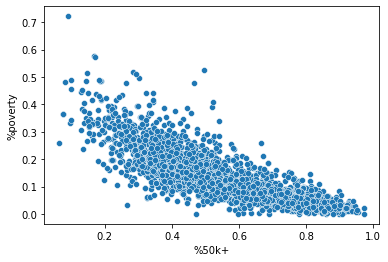

In [13]:
sns.scatterplot(totalData["%50k+"],totalData["%poverty"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

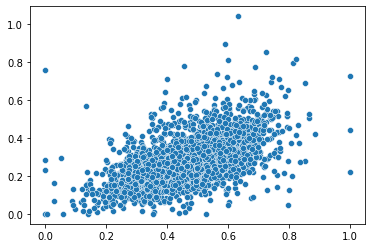

In [21]:
sns.scatterplot(totalData["%<25k"]/(1-totalData["%50k+"]),totalData["%poverty"]/(1-totalData["%50k+"]))

In [30]:
test=to_ilr(totalData[["%<25k","%50k+"]],"ILRPoverty")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='%<25k', ylabel='ILRPoverty_1'>

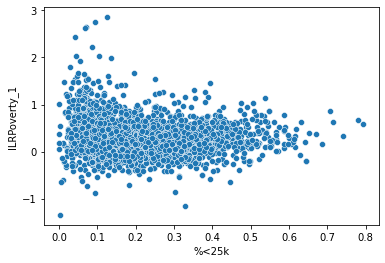

In [32]:
sns.scatterplot(totalData["%<25k"],test.iloc[:,1])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='%25k-50k', ylabel='ILRPoverty_1'>

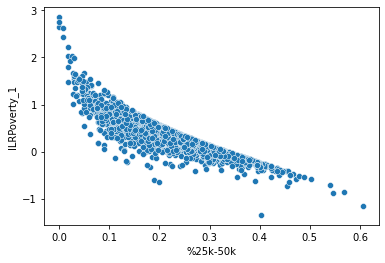

In [33]:
sns.scatterplot(totalData["%25k-50k"],test.iloc[:,1])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='%50k+', ylabel='ILRPoverty_1'>

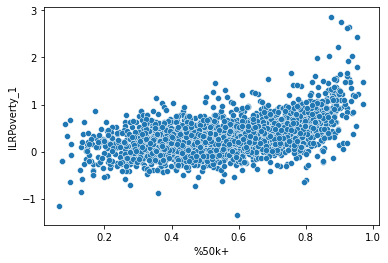

In [35]:
sns.scatterplot(totalData["%50k+"],test.iloc[:,1])